In [45]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score, confusion_matrix, accuracy_score, recall_score,
    classification_report, precision_score, f1_score, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc, average_precision_score
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.utils import class_weight
from sklearn.ensemble import StackingClassifier

# xgboost / lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# imbalanced-learn (Oversampling)
from imblearn.over_sampling import SMOTE

# tensorflow/keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt  # Keras-Tuner zum Hyperparameter-Tuning

In [46]:
# Datensatz einlesen
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# kleiner Überblick
print(df.head())
print(df.info())
df.head()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

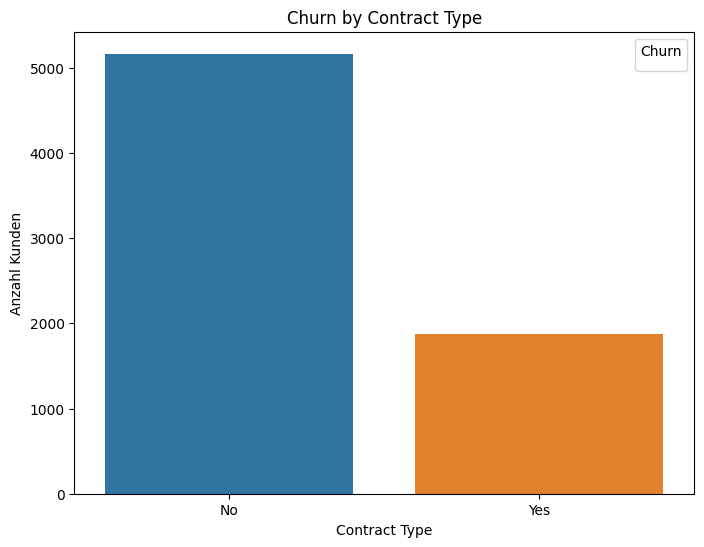

Total Customers: 7032
Churn Rate: 26.58%
Average Monthly Charges: 64.80
Average Total Charges: 2283.30


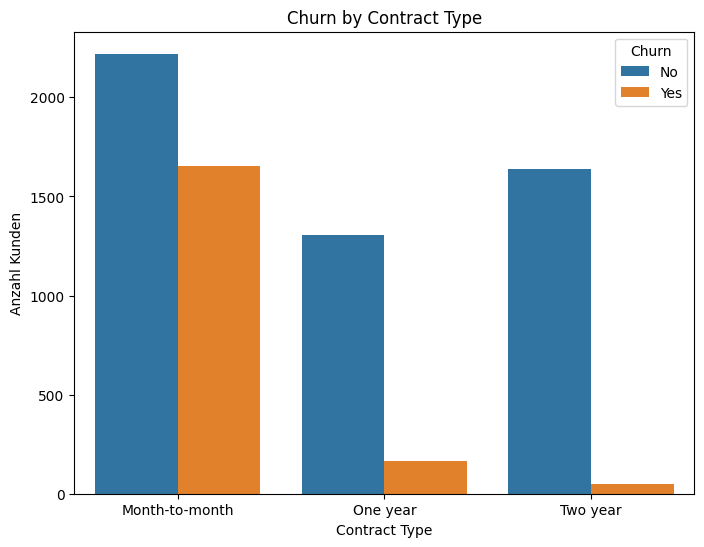

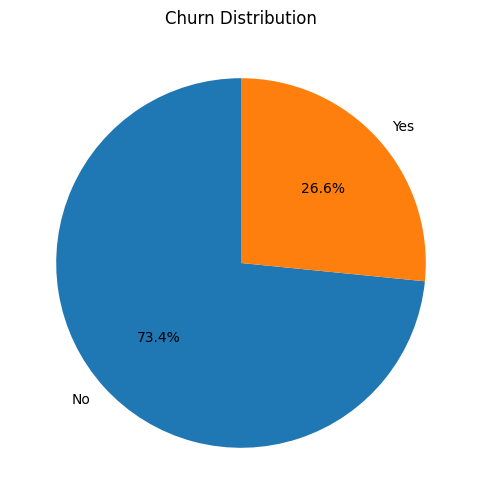

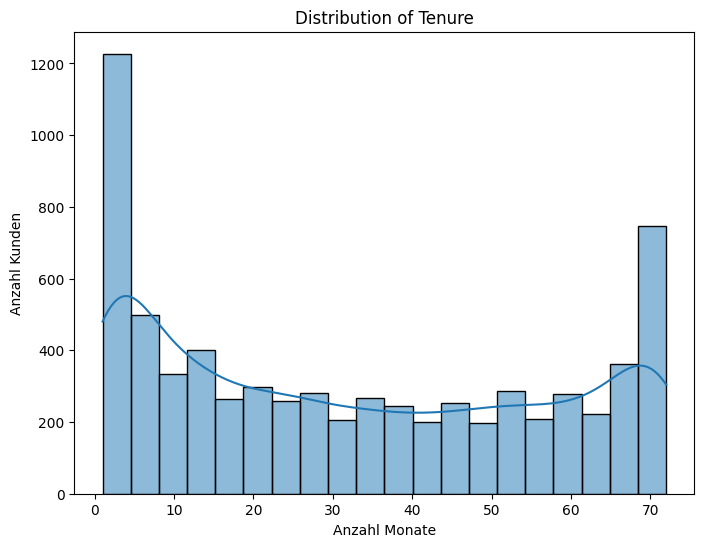

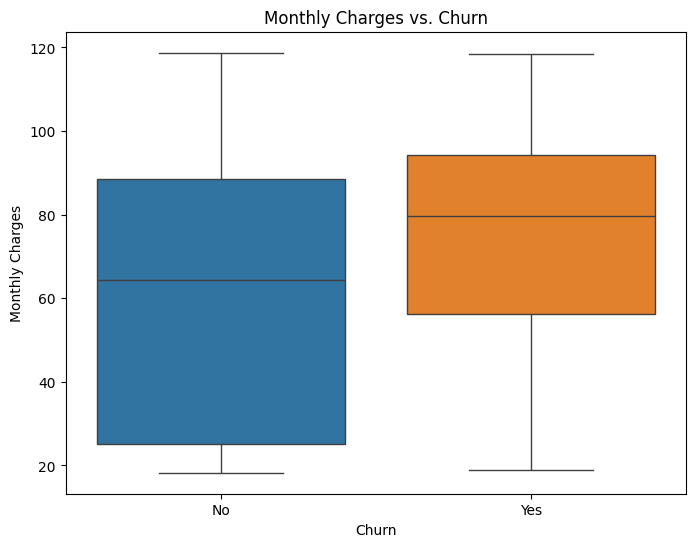

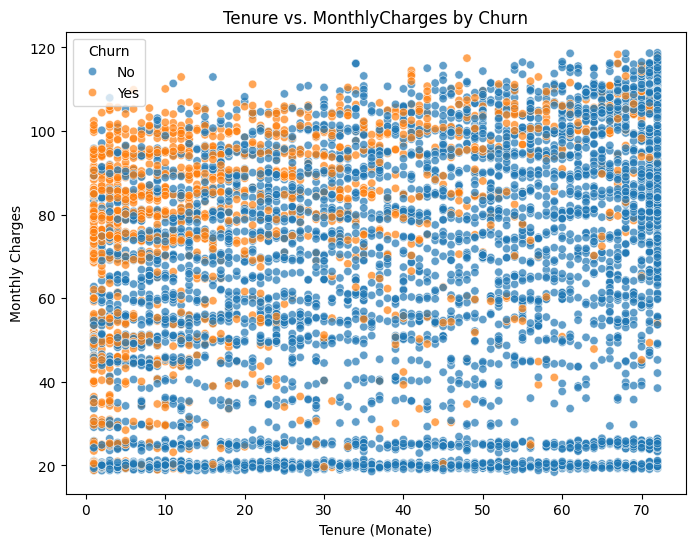

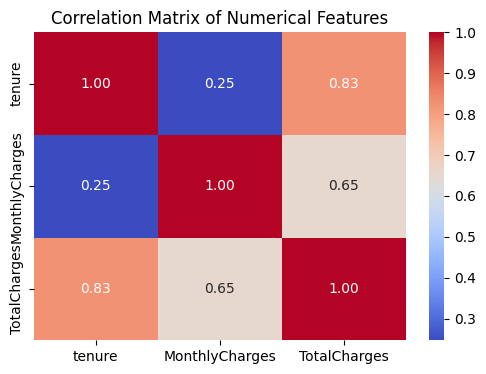

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Standard Farbpalette definieren (Blau, Orange, Grün, Rot, Violett)
common_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
# Für kontinuierliche Daten (z. B. in Heatmaps) verwenden wir einen separaten Colormap
common_cmap = sns.color_palette("coolwarm", as_cmap=True)

# Falls TotalCharges als Objekt vorliegt, in numerisch umwandeln (fehlerhafte Werte werden zu NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)  # Entfernt Zeilen mit fehlenden Werten

# ----------------------------
# 1. Churn Verteilung
# ----------------------------
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Churn", hue="Churn", palette=common_palette)
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Anzahl Kunden")
plt.legend(title="Churn")
plt.show()

# ----------------------------
# KPI-Berechnungen
# ----------------------------
total_customers = df.shape[0]
churn_rate = df[df["Churn"]=="Yes"].shape[0] / total_customers
avg_monthly_charges = df["MonthlyCharges"].mean()
avg_total_charges = df["TotalCharges"].mean()

print("Total Customers:", total_customers)
print("Churn Rate: {:.2%}".format(churn_rate))
print("Average Monthly Charges: {:.2f}".format(avg_monthly_charges))
print("Average Total Charges: {:.2f}".format(avg_total_charges))

# ----------------------------
# 2. Balkendiagramm: Churn nach Vertragsart
# ----------------------------
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Contract", hue="Churn", palette=common_palette)
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Anzahl Kunden")
plt.legend(title="Churn")
plt.show()

# ----------------------------
# 3. Kreisdiagramm: Verteilung der Churn-Labels
# ----------------------------
churn_counts = df["Churn"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct="%1.1f%%", 
        colors=common_palette, startangle=90)
plt.title("Churn Distribution")
plt.show()

# ----------------------------
# 4. Histogramm: Verteilung der Tenure
# ----------------------------
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="tenure", bins=20, kde=True, color=common_palette[0])
plt.title("Distribution of Tenure")
plt.xlabel("Anzahl Monate")
plt.ylabel("Anzahl Kunden")
plt.show()

# ----------------------------
# 5. Boxplot: MonthlyCharges vs. Churn
# ----------------------------
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Churn", y="MonthlyCharges", palette=common_palette)
plt.title("Monthly Charges vs. Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

# ----------------------------
# 6. Scatterplot: Tenure vs. MonthlyCharges (farblich nach Churn)
# ----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="tenure", y="MonthlyCharges", hue="Churn", 
                palette=common_palette, alpha=0.7)
plt.title("Tenure vs. MonthlyCharges by Churn")
plt.xlabel("Tenure (Monate)")
plt.ylabel("Monthly Charges")
plt.show()

# ----------------------------
# 7. Heatmap: Korrelation numerischer Variablen
# ----------------------------
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
corr_matrix = df[num_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap=common_cmap, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


# Feature Engineering



In [48]:
# Datensatz einlesen
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# TotalCharges bereinigen
df = df[df['TotalCharges'].str.strip().replace('', float('NaN')).notna()]
df['TotalCharges'] = df['TotalCharges'].astype(float)

# Churn in 0/1 umwandeln
df['Churn'] = df['Churn'].map({"Yes": 1, "No": 0})
X = df.drop(columns=["customerID", "Churn"])
y = df.Churn

# Train-/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Listen initialisieren
num_cols = []  # Für numerische Datentypen
cat_cols = []  # Für kategoriale Datentypen

# Spalten durchgehen und Datentypen überprüfen
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:  # Numerische Datentypen
        num_cols.append(col)
    elif X[col].dtype == 'object':            # Kategoriale Datentypen
        cat_cols.append(col)

# SeniorCitizen als kategorial behandeln
num_cols.remove('SeniorCitizen')
cat_cols.append('SeniorCitizen')

# Ergebnisse ausgeben
print("Numerische Spalten:", num_cols)
print("Kategoriale Spalten:", cat_cols)

# Pipeline für Kategoriale Features
cat = Pipeline(steps=[
    ('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Pipeline für Numerische Features
num = Pipeline(steps=[
    ('num_scale', RobustScaler())
])

# Zusammenführen in ColumnTransformer
pre = ColumnTransformer(
    transformers=[
        ('num', num, num_cols),
        ('cat', cat, cat_cols)
    ]
)


Numerische Spalten: ['tenure', 'MonthlyCharges', 'TotalCharges']
Kategoriale Spalten: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


# Basismodell: RandomForest



In [49]:
# Nutzung der Pipeline
main_pipeline = Pipeline(steps=[
    ('preprocess', pre),
    ('classifier', RandomForestClassifier())
])
# Parameterverteilungen (gleich wie bei GridSearchCV)
param_grid = {
    'classifier': [RandomForestClassifier(bootstrap=True)],
    'classifier__n_estimators': [50, 100, 200, 300, 500],
    'classifier__max_depth': [10, 20, 30, 50, None],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
}

# RandomizedSearchCV initialisieren:
random_search = RandomizedSearchCV(
    estimator=main_pipeline,
    param_distributions=param_grid,
    n_iter=10,               # Anzahl der zufällig zu testenden Kombinationen
    cv=3,
    scoring='recall',
    verbose=3,
    error_score='raise',
    n_jobs=-1,
    random_state=42          # Für Reproduzierbarkeit
)

# Suche auf den Trainingsdaten durchführen
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_scale',
                                                                                                RobustScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('cat_ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['gender',
                                                                                'Partner',
                                                                                'Depend...
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier': [RandomForestClassifier()],
                                        'classifier__class_weight': [{0: 1,
                                                                      1: 2},
                                                                     {0: 1,
                                                                      1: 3}],
                                        'classifier__max_depth': [10, 20, 30,
                                                                  50, None],
                                        'classifier__min_samples_leaf': [1, 5,
                                                                         10,
                                                                         20],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10,
                                                                          15],
                                        'classifier__n_estimators': [50, 100,
                                                                     200, 300,
                                                                     500]},
                   random_state=42, scoring='recall', verbose=3)


===================== Grid Search Results =====================
Best X Score: 0.783
Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 30, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier': RandomForestClassifier()}
Confusion Matrix:
[[1118  431]
 [ 107  454]]


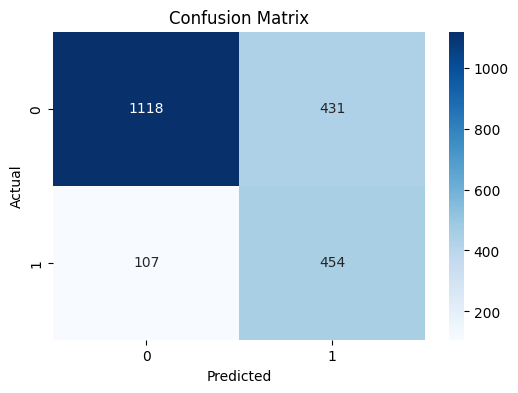


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1549
           1       0.51      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.71      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110

Accuracy: 74.50%


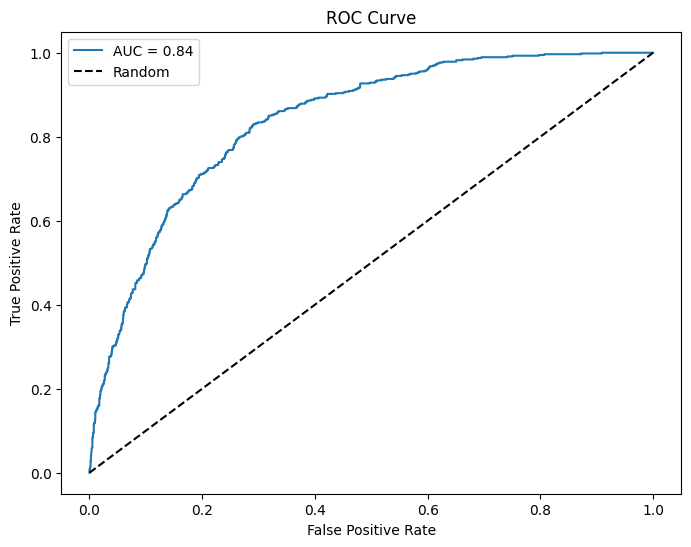

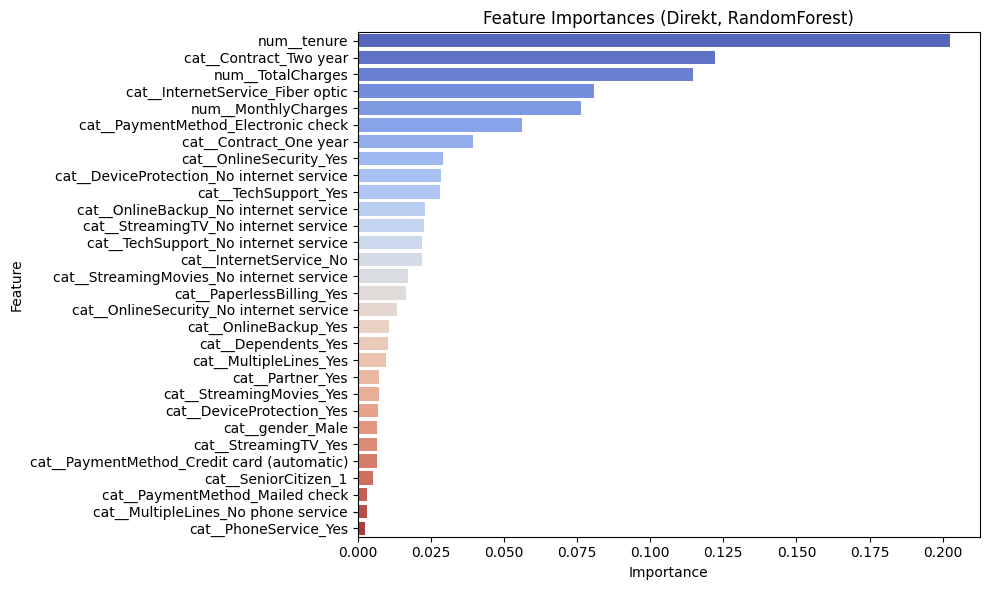

Direkte Feature Importances:
                                       Feature  Importance
0                                  num__tenure    0.202622
24                      cat__Contract_Two year    0.122199
2                            num__TotalCharges    0.114747
9             cat__InternetService_Fiber optic    0.080762
1                          num__MonthlyCharges    0.076308
27         cat__PaymentMethod_Electronic check    0.056225
23                      cat__Contract_One year    0.039396
12                     cat__OnlineSecurity_Yes    0.029241
15   cat__DeviceProtection_No internet service    0.028499
18                        cat__TechSupport_Yes    0.028284
13       cat__OnlineBackup_No internet service    0.022896
19        cat__StreamingTV_No internet service    0.022585
17        cat__TechSupport_No internet service    0.022030
10                     cat__InternetService_No    0.021825
21    cat__StreamingMovies_No internet service    0.017103
25                   cat__P

In [51]:

# Ausgabe der Suchergebnisse
print("\n===================== Grid Search Results =====================")
print(f"Best X Score: {round(random_search.best_score_, 3)}")
print(f"Best Parameters: {random_search.best_params_}")

# Bestes Modell aus der RandomizedSearchCV
best_model = random_search.best_estimator_

# --------------------------
# Evaluation
# --------------------------

# Erzeuge Vorhersagen und Wahrscheinlichkeiten auf dem Testset
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für Klasse 1

# a) Confusion Matrix (Labels: 0 und 1)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# b) Classification Report und Accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# c) ROC-Kurve und AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc_value))
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --------------------------
# Feature Importance
# --------------------------

# Direkte Feature Importance, wenn der Klassifikator diese unterstützt (z.B. RandomForest)
classifier = best_model.named_steps["classifier"]
if hasattr(classifier, "feature_importances_"):
    importances = classifier.feature_importances_
    try:
        # Versuche, die Feature-Namen aus dem Preprocessing-Schritt zu extrahieren
        feature_names = best_model.named_steps["preprocess"].get_feature_names_out()
    except Exception as e:
        print("Fehler beim Abrufen der Feature-Namen:", e)
        feature_names = [f"Feature_{i}" for i in range(len(importances))]
    
    if len(feature_names) != len(importances):
        feature_names = [f"Feature_{i}" for i in range(len(importances))]
    
    feat_imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="coolwarm")
    plt.title("Feature Importances (Direkt, RandomForest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
    print("Direkte Feature Importances:")
    print(feat_imp_df)
else:
    print("Der verwendete Klassifikator unterstützt keine direkte Feature Importance.")



# Ensemble-Modelle: Multiple Ansätze


----- Evaluating model: lr -----
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Beste Parameter: {'classifier__class_weight': {0: 1, 1: 2}, 'classifier__C': 10.0}
Bester F1-Score (CV): 0.6355676416645689

Confusion Matrix:
[[1198  351]
 [ 149  412]]


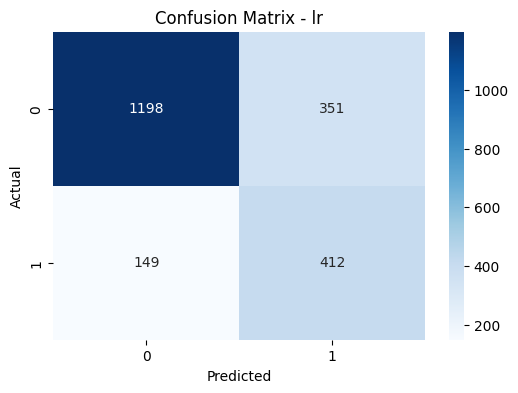


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1549
           1       0.54      0.73      0.62       561

    accuracy                           0.76      2110
   macro avg       0.71      0.75      0.72      2110
weighted avg       0.80      0.76      0.77      2110

Accuracy: 76.30%


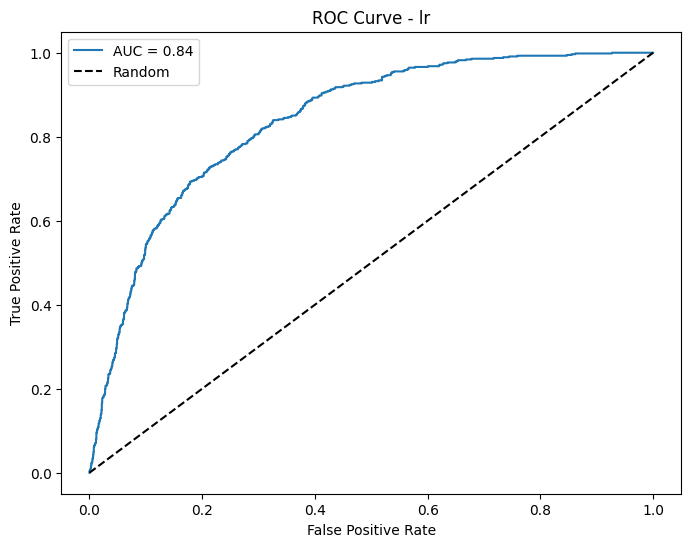


----- Evaluating model: svm -----
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Beste Parameter: {'classifier__class_weight': {0: 1, 1: 2}, 'classifier__C': 1.0}
Bester F1-Score (CV): 0.6320086765690645

Confusion Matrix:
[[1207  342]
 [ 147  414]]


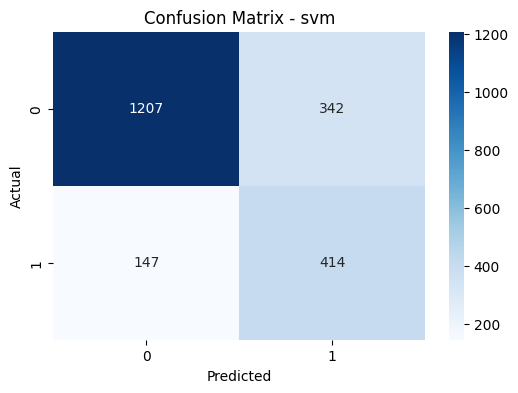


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1549
           1       0.55      0.74      0.63       561

    accuracy                           0.77      2110
   macro avg       0.72      0.76      0.73      2110
weighted avg       0.80      0.77      0.78      2110

Accuracy: 76.82%


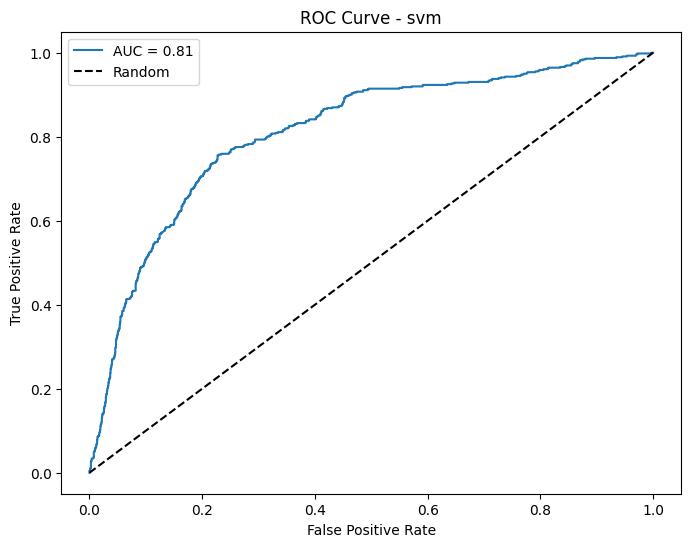


----- Evaluating model: rf -----
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Beste Parameter: {'classifier__n_estimators': 200, 'classifier__class_weight': {0: 1, 1: 3}}
Bester F1-Score (CV): 0.5606683617378636

Confusion Matrix:
[[1386  163]
 [ 298  263]]


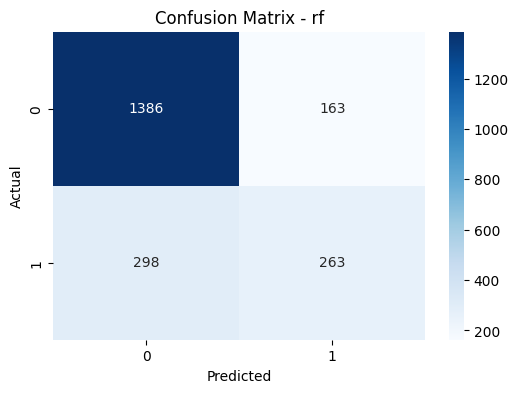


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.62      0.47      0.53       561

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110

Accuracy: 78.15%


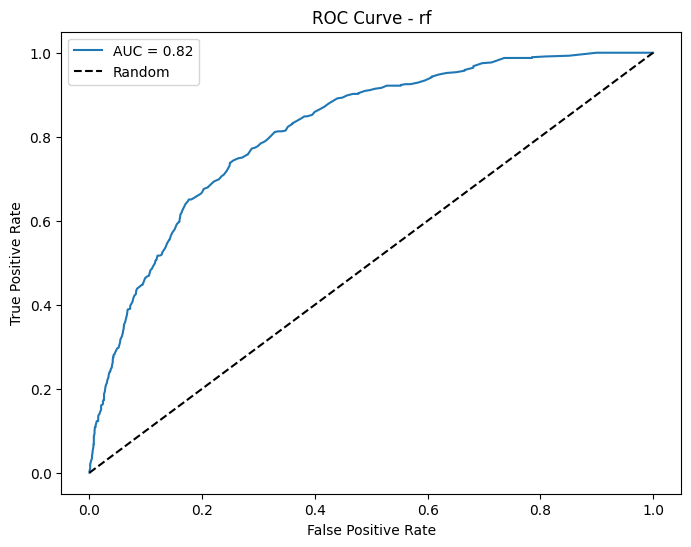


----- Evaluating model: xgb -----
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Beste Parameter: {'classifier__n_estimators': 50}
Bester F1-Score (CV): 0.5573049115461705

Confusion Matrix:
[[1368  181]
 [ 274  287]]


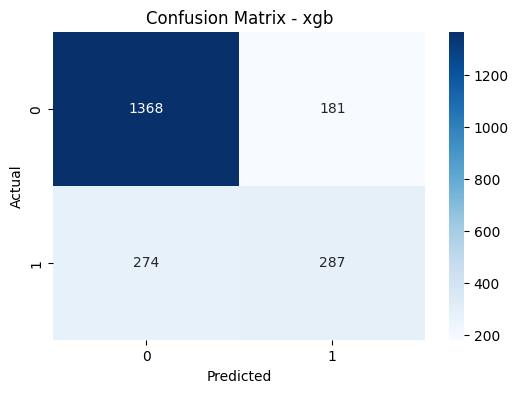


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1549
           1       0.61      0.51      0.56       561

    accuracy                           0.78      2110
   macro avg       0.72      0.70      0.71      2110
weighted avg       0.77      0.78      0.78      2110

Accuracy: 78.44%


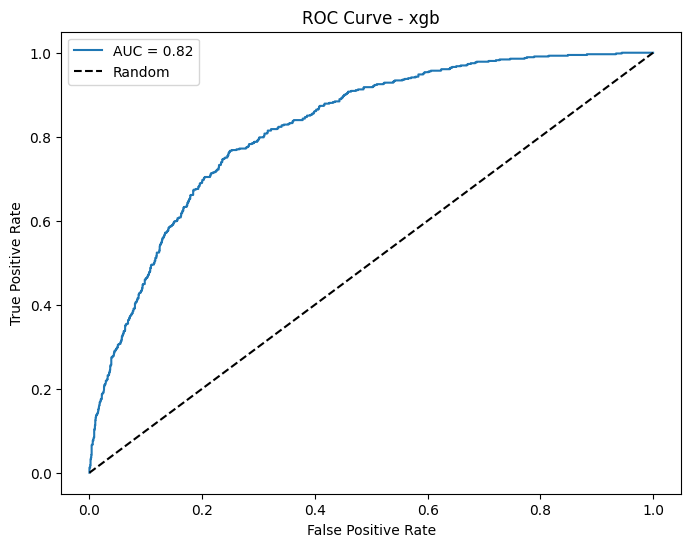


----- Evaluating model: lgbm -----
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520562 -> initscore=0.082296
[LightGBM] [Info] Start training from score 0.082296
Beste Parameter: {'classifier__n_estimators': 50, 'classifier__class_weight': {0: 1, 1: 3}}
Bester F1-Score (CV): 0.6215365359432087

Confusion Matrix:
[[1133  416]
 [ 125  436]]


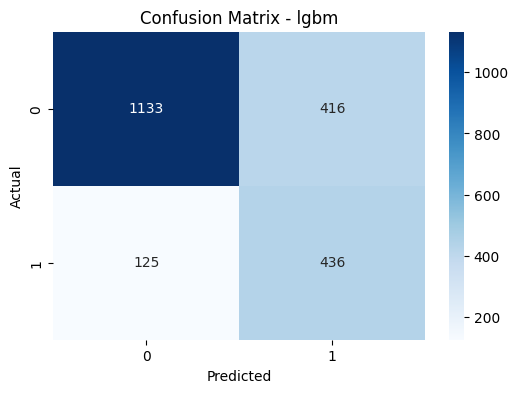


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1549
           1       0.51      0.78      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.80      0.74      0.76      2110

Accuracy: 74.36%


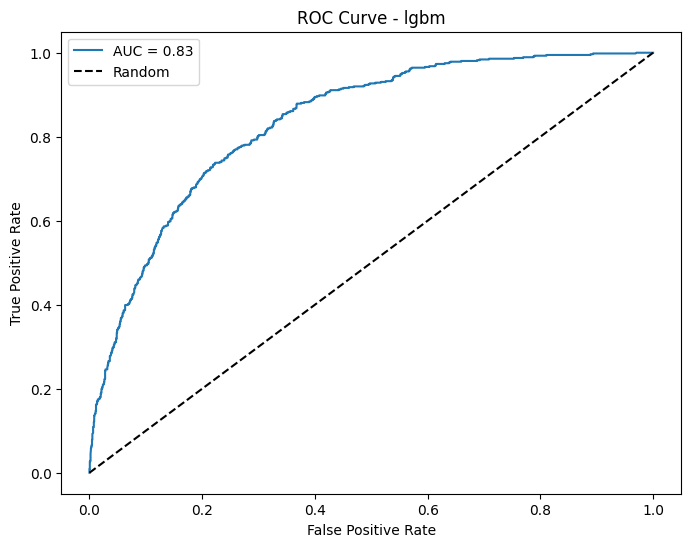


=== Gesamtvergleich der Modelle ===


,Model,Best_F1_CV,Test_Accuracy,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC
0,lr,0.635568,0.763033,0.734403,0.539974,0.622356,0.837561
1,svm,0.632009,0.768246,0.737968,0.547619,0.628702,0.811532
2,rf,0.560668,0.781517,0.468806,0.617371,0.532928,0.816020
3,xgb,0.557305,0.784360,0.511586,0.613248,0.557823,0.822492
4,lgbm,0.621537,0.743602,0.777184,0.511737,0.617127,0.834909


In [18]:
# Modelle definieren
models = {
    'lr':  LogisticRegression(solver='liblinear', random_state=42),
    'svm': SVC(probability=True, random_state=42),
    'rf':  RandomForestClassifier(bootstrap=True, n_estimators=100, random_state=42),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'lgbm':LGBMClassifier(random_state=42)
}

# Parametergrids (ohne RFE und Feature Importance)
param_grids = {
    'lr': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
    },
    'svm': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
    },
    'rf': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
    },
    'xgb': {
        'classifier__n_estimators': [50, 100, 200]
        # XGBoost unterstützt class_weight nicht
    },
    'lgbm': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
    }
}

results = {}  # Speichert das RandomizedSearchCV-Objekt pro Modell
all_results = []  # Speichert die finalen Metriken zum Vergleich



# Modelle trainieren und evaluieren
for name, model in models.items():
    print(f"\n----- Evaluating model: {name} -----")
    
    # Pipeline: Preprocessing -> Klassifikator
    pipeline = Pipeline(steps=[
        ('preprocess', pre),  # Deine Preprocessing-Pipeline (ColumnTransformer, etc.)
        ('classifier', model)
    ])
    
    # RandomizedSearchCV
    rs = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grids[name],
        n_iter=10,  # Anzahl zufällig getesteter Kombinationen
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        verbose=3,
        n_jobs=-1,
        random_state=42,
        error_score='raise'
    )
    
    # Training + Hyperparameter-Suche
    rs.fit(X_train, y_train)
    print("Beste Parameter:", rs.best_params_)
    print("Bester F1-Score (CV):", rs.best_score_)
    
    # Speichere das Resultat-Objekt
    results[name] = rs

    # --- Evaluation auf den Testdaten ---
    best_model = rs.best_estimator_  # Das beste gefundene Pipeline-Modell
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["0", "1"]))
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    # AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    auc_value = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc_value))
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()
    
    # Zusätzliche Metriken
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)
    
    # Sammle Ergebnisse für den direkten Vergleich
    all_results.append({
        'Model': name,
        'Best_F1_CV': rs.best_score_,
        'Test_Accuracy': acc,
        'Test_Recall': rec,
        'Test_Precision': prec,
        'Test_F1': f1_test,
        'Test_ROC_AUC': auc_value
    })


# Modelle direkt vergleichen: tabellarische Übersicht
comparison_df = pd.DataFrame(all_results)
print("\n=== Gesamtvergleich der Modelle ===")
comparison_df

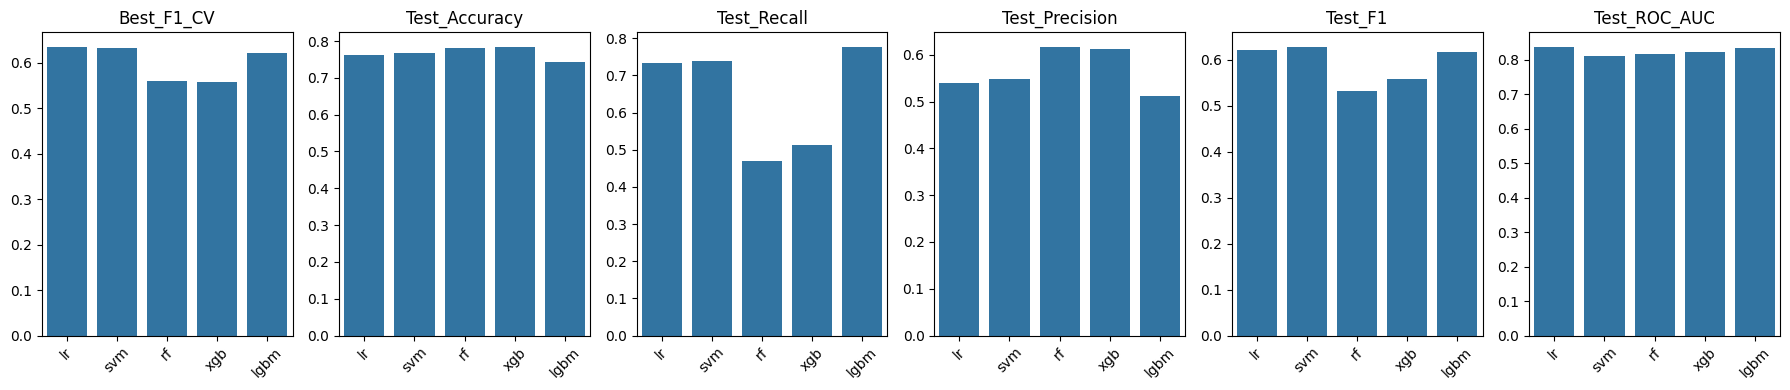

In [19]:
metrics_to_plot = [
    'Best_F1_CV',
    'Test_Accuracy',
    'Test_Recall',
    'Test_Precision',
    'Test_F1',
    'Test_ROC_AUC'
]

# Erstelle Subplots (pro Metrik einen Balkenplot)
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(18, 4))

for ax, metric in zip(axes, metrics_to_plot):
    # Balkendiagramm für jede Metrik
    sns.barplot(ax=ax, x='Model', y=metric, data=comparison_df)
    ax.set_title(metric)        # Titel = Name der Metrik
    ax.set_xlabel('')           # X-Achsenlabel ausblenden (Modellnamen stehen schon auf X-Achse)
    ax.set_ylabel('')           # Y-Achse (optional) leer
    ax.tick_params(axis='x', rotation=45)  # Modellnamen leicht schräg

plt.tight_layout()
plt.show()


# Ensemble Learning: Stacking-Methode

In [5]:
# Basis-Modelle für den StackingClassifier definieren
base_estimators = [
    ('lr', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)),
    ('svm', SVC(C=1.0, kernel='rbf', probability=True, random_state=42)),
    ('rf', RandomForestClassifier(bootstrap=True, n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Meta-Classifier definieren
meta_estimator = LogisticRegression(random_state=42)

# StackingClassifier erstellen
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_estimator,
    cv=3,
    n_jobs=-1
)

# RFE als Feature Selection-Schritt integrieren (verwenden Logistic Regression als Estimator)
rfe = RFE(estimator=LogisticRegression(solver='liblinear', random_state=42))

# Pipeline erstellen: Preprocessing -> RFE -> StackingClassifier
main_pipeline_stacking = Pipeline(steps=[
    ('preprocess', pre),              # Deine bestehende Preprocessing-Pipeline (z. B. ColumnTransformer)
    ('feature_selection', rfe),       # RFE zur Feature-Auswahl
    ('classifier', stacking_clf)      # Stacking-Classifier
])

# Parameterverteilungen mit numerischen class_weight-Dictionaries
param_distributions = {
    'feature_selection__n_features_to_select': [10, 20, 30],
    'classifier__final_estimator__C': [0.1, 1.0, 10.0],
    'classifier__lr__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
    'classifier__svm__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
    'classifier__rf__n_estimators': [50, 100, 200],
    'classifier__rf__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}],
    'classifier__xgb__n_estimators': [50, 100, 200],
    'classifier__lgbm__class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
}

# Verwende StratifiedKFold, um eine repräsentative Klassenverteilung in jedem Fold zu gewährleisten
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialisiere RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=main_pipeline_stacking,
    param_distributions=param_distributions,
    n_iter=10,               # Anzahl zufällig getesteter Kombinationen
    cv=cv,
    scoring='f1',
    verbose=3,
    n_jobs=-1,
    random_state=42,
    error_score='raise'
)

# Führe die Suche auf den Trainingsdaten durch
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_scale',
                                                                                                RobustScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('cat_ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='igno...
                                                                           {0: 1,
                                                                            1: 3}],
                                        'classifier__lr__class_weight': [{0: 1,
                                                                          1: 2},
                                                                         {0: 1,
                                                                          1: 3}],
                                        'classifier__rf__class_weight': [{0: 1,
                                                                          1: 2},
                                                                         {0: 1,
                                                                          1: 3}],
                                        'classifier__rf__n_estimators': [50,
                                                                         100,
                                                                         200],
                                        'classifier__svm__class_weight': [{0: 1,
                                                                           1: 2},
                                                                          {0: 1,
                                                                           1: 3}],
                                        'classifier__xgb__n_estimators': [50,
                                                                          100,
                                                                          200],
                                        'feature_selection__n_features_to_select': [10,
                                                                                    20,
                                                                                    30]},
                   random_state=42, scoring='f1', verbose=3)

Beste Parameter: {'feature_selection__n_features_to_select': 30, 'classifier__xgb__n_estimators': 100, 'classifier__svm__class_weight': {0: 1, 1: 3}, 'classifier__rf__n_estimators': 200, 'classifier__rf__class_weight': {0: 1, 1: 2}, 'classifier__lr__class_weight': {0: 1, 1: 3}, 'classifier__lgbm__class_weight': {0: 1, 1: 3}, 'classifier__final_estimator__C': 10.0}
Bester F1-Score: 0.5944738389182834
Confusion Matrix:
[[1380  169]
 [ 253  308]]


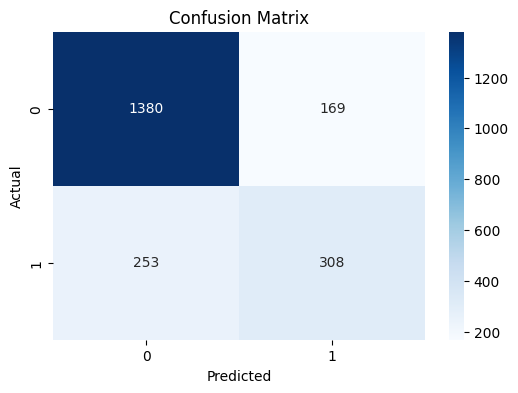


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.65      0.55      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.79      2110

Accuracy: 80.00%


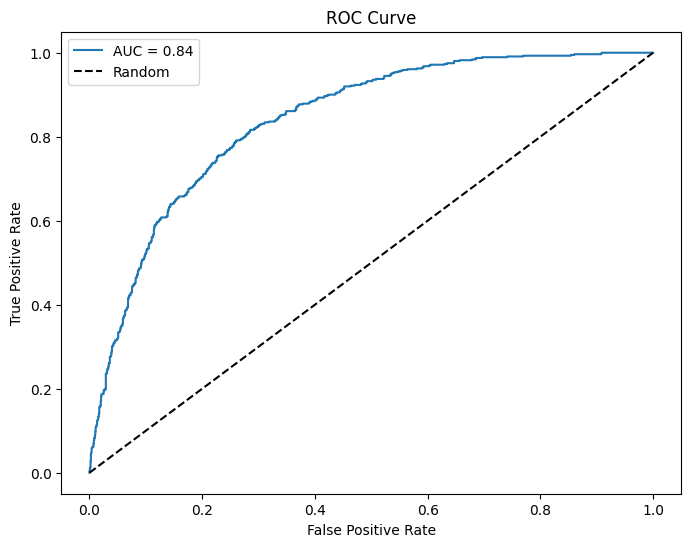

In [7]:
# best_model definieren!
best_model = random_search.best_estimator_

# Ausgabe der besten Parameter und des besten F1-Scores
print("Beste Parameter:", random_search.best_params_)
print("Bester F1-Score:", random_search.best_score_)
# Vorhersagen auf dem Testset generieren
y_pred = best_model.predict(X_test)

# Evaluation: Confusion Matrix, Classification Report, Accuracy und ROC-AUC
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# ROC-Kurve
y_proba = best_model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeit für Klasse 1
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc_value))
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Neuronales Netzwerk: Basisarchitektur


In [10]:
# Wende den Preprocessing-Pipeline auf Trainings- und Testdaten an
X_train_pre = pre.fit_transform(X_train)
X_test_pre = pre.transform(X_test)

# Erstelle ein einfaches neuronales Netzwerk
model = Sequential([
    # Erste Dense-Schicht mit 16 Neuronen und ReLU-Aktivierung; input_shape passt sich der Anzahl der Features an
    Dense(32, activation='relu', input_shape=(X_train_pre.shape[1],)),
    # Dropout-Schicht zur Regularisierung (reduziert Overfitting)
    Dropout(0.2),
    # Zweite Dense-Schicht mit 8 Neuronen und ReLU-Aktivierung
    Dense(16, activation='relu'),
    # Ausgangsschicht: 1 Neuron mit Sigmoid-Aktivierung (für binäre Klassifikation)
    Dense(1, activation='sigmoid')
])

# Kompiliere das Modell mit Adam-Optimierer und binärer Kreuzentropie als Loss-Funktion
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trainiere das Modell; passe die Anzahl der Epochen und die Batchgröße bei Bedarf an
history = model.fit(X_train_pre, y_train,
                    validation_data=(X_test_pre, y_test),
                    epochs=50,
                    batch_size=32)

# Evaluierung des Modells auf den Testdaten
loss, accuracy = model.evaluate(X_test_pre, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7304 - loss: 0.5451 - val_accuracy: 0.7858 - val_loss: 0.4498
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4410 - val_accuracy: 0.7962 - val_loss: 0.4426
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7874 - loss: 0.4310 - val_accuracy: 0.8009 - val_loss: 0.4342
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7818 - loss: 0.4378 - val_accuracy: 0.8033 - val_loss: 0.4309
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4317 - val_accuracy: 0.8024 - val_loss: 0.4288
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4187 - val_accuracy: 0.8009 - val_loss: 0.4279
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.4318 - val_accuracy: 0.8043 - val_loss: 0.4269
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 0.4091 - val_accuracy: 0.

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
=== Evaluation Metrics ===
Accuracy: 0.7896
Precision: 0.6396
Recall: 0.4777
F1 Score: 0.5469
ROC AUC: 0.8269

Confusion Matrix:
[[1398  151]
 [ 293  268]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.48      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.78      0.79      0.78      2110



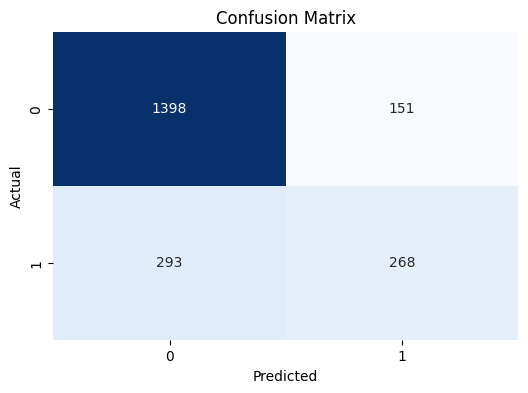

In [11]:
# Vorhersagen für die Testdaten
y_pred_prob = model.predict(X_test_pre)  # Wahrscheinlichkeiten
y_pred = (y_pred_prob > 0.5).astype(int)   # Klassenvorhersagen mittels Threshold 0.5

# Berechnung der wichtigsten Metriken
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("=== Evaluation Metrics ===")
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(prec))
print("Recall: {:.4f}".format(rec))
print("F1 Score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Ausführlicher Klassifikationsbericht
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optionale Visualisierung der Konfusionsmatrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Neuronales Netzwerk: Erweiterte Architektur


Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.7388625741004944

Best val_accuracy So Far: 0.7763032913208008
Total elapsed time: 00h 02m 38s

Best hyperparameters: {'num_layers': 3, 'units_0': 32, 'activation_0': 'tanh', 'reg_type_0': 'l1', 'reg_0': 1.0268621446033616e-05, 'use_batchnorm_0': False, 'dropout_0': 0.4, 'lr': 0.0003233648014907526, 'units_1': 32, 'activation_1': 'tanh', 'reg_type_1': 'l2', 'reg_1': 0.0002240466341792675, 'use_batchnorm_1': True, 'dropout_1': 0.1, 'l1_1': 0.003023169658342641, 'l2_1': 0.0002539745515224935, 'units_2': 128, 'activation_2': 'relu', 'reg_type_2': 'l2', 'reg_2': 3.6879810079731373e-05, 'use_batchnorm_2': True, 'dropout_2': 0.0, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5691 - loss: 0.7715 - val_accuracy: 0.7498 - val_loss: 0.5725 - learning_rate: 3.2336e-04
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7121 - loss: 0.

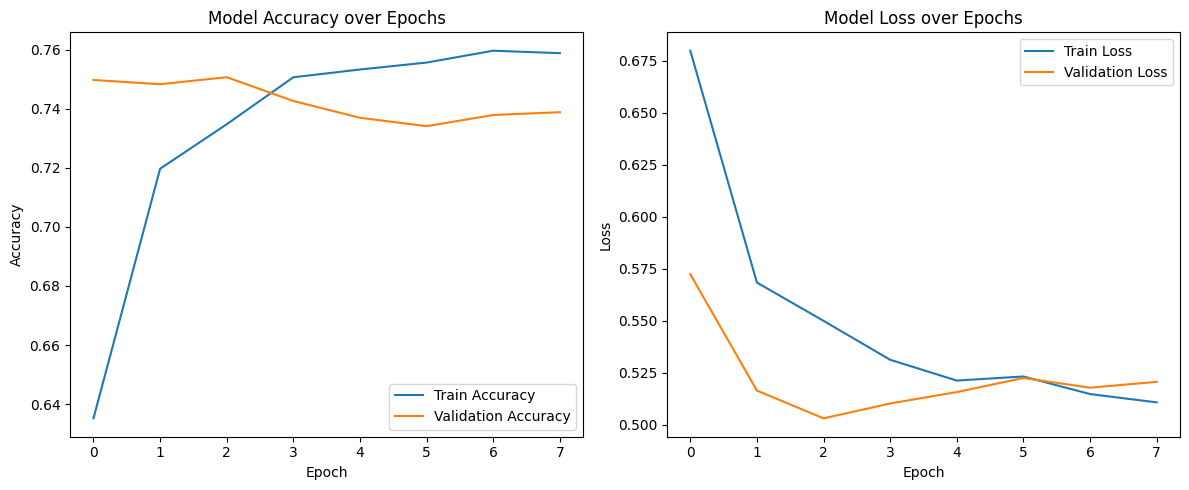

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Final Evaluation Metrics ===
Accuracy: 0.7507
Precision: 0.5218
Recall: 0.7469
F1 Score: 0.6144
ROC AUC: 0.8239

Confusion Matrix:
[[1165  384]
 [ 142  419]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1549
           1       0.52      0.75      0.61       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.72      2110
weighted avg       0.79      0.75      0.76      2110



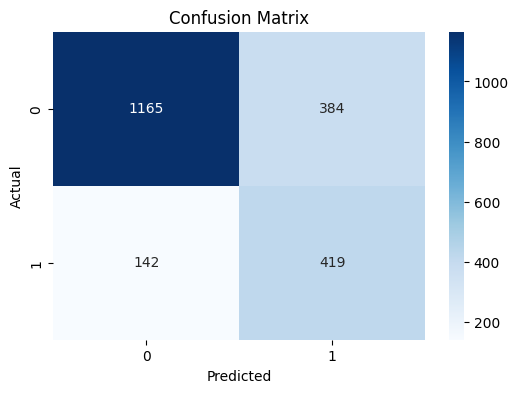

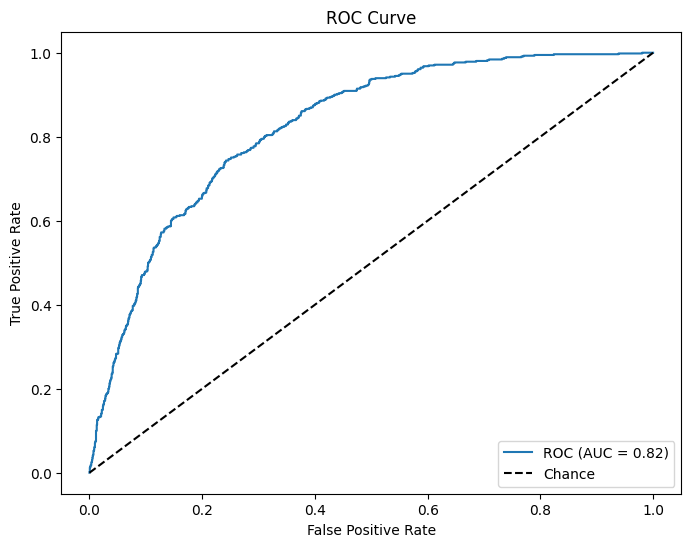

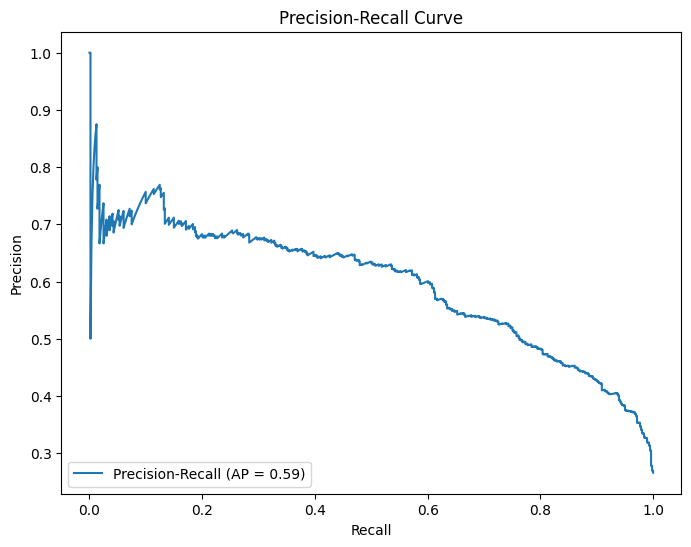

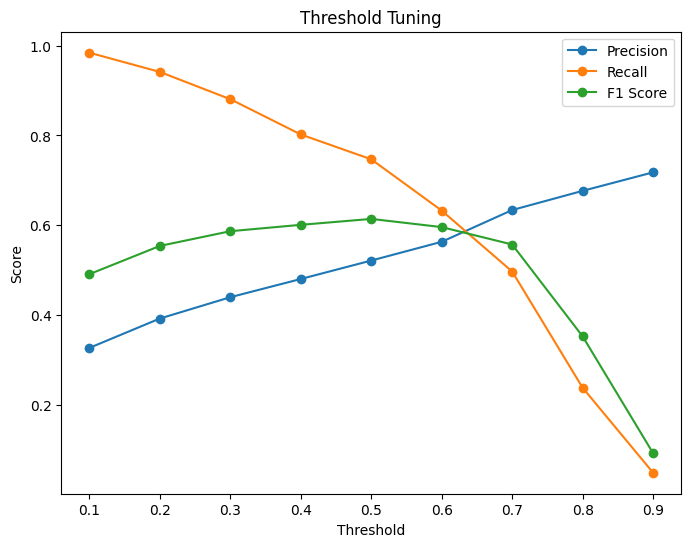

In [13]:
# Zufallskeim für Reproduzierbarkeit
np.random.seed(42)
tf.random.set_seed(42)

# Klassenverteilung prüfen
orig_classes, orig_counts = np.unique(y_train, return_counts=True)
print("Original training distribution:", dict(zip(orig_classes, orig_counts)))

# Oversampling mit SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pre, y_train)
new_classes, new_counts = np.unique(y_train_res, return_counts=True)
print("After SMOTE distribution:", dict(zip(new_classes, new_counts)))

# Klassengewichte berechnen
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res),
    y=y_train_res
)
class_weights = {i: w for i, w in enumerate(weights)}
print("Computed class weights:", class_weights)

# Keras Tuner: Modellaufbau-Funktion
def build_model_tuner(hp):
    """
    Erzeugt ein Keras Sequential-Modell mit variabler Architektur:
      - Anzahl der Hidden Layers (1-3)
      - Neuronen pro Layer (16, 32, 64, 128)
      - Aktivierungsfunktion (relu oder tanh)
      - Regularisierung (l1, l2, l1_l2) mit wählbarem Faktor
      - BatchNormalization optional
      - Dropout-Rate (0.0 - 0.5)
      - Lernrate (1e-4 bis 1e-2, logarithmisch verteilt)
    """
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', values=[16, 32, 64, 128])
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        reg_type = hp.Choice(f'reg_type_{i}', values=['l1', 'l2', 'l1_l2'])
        
        if reg_type == 'l1':
            reg = l1(hp.Float(f'reg_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        elif reg_type == 'l2':
            reg = l2(hp.Float(f'reg_{i}', min_value=1e-5, max_value=1e-2, sampling='log'))
        else:
            l1_val = hp.Float(f'l1_{i}', min_value=1e-5, max_value=1e-2, sampling='log')
            l2_val = hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-2, sampling='log')
            reg = l1_l2(l1=l1_val, l2=l2_val)

        model.add(Dense(units, activation=activation, kernel_regularizer=reg))
        
        if hp.Boolean(f'use_batchnorm_{i}'):
            model.add(BatchNormalization())
        
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperband-Tuner einrichten
tuner = kt.Hyperband(
    build_model_tuner,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='churn_tuning',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Hyperparameter-Suche
tuner.search(
    X_train_res, y_train_res,
    epochs=20,
    validation_data=(X_test_pre, y_test),
    callbacks=[stop_early],
    class_weight=class_weights
)

best_hps_list = tuner.get_best_hyperparameters()
best_hps = best_hps_list[0]
print("\nBest hyperparameters:", best_hps.values)

# Bestes Modell mit den gefundenen Hyperparametern erstellen
best_model = tuner.hypermodel.build(best_hps)

early_stop_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = best_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test_pre, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop_final, reduce_lr_final],
    class_weight=class_weights
)

# Trainingsverlauf (Accuracy & Loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Finale Evaluation
y_pred_prob = best_model.predict(X_test_pre).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc_val = roc_auc_score(y_test, y_pred_prob)

print("\n=== Final Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc_val:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC & Precision-Recall-Kurven
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_val2 = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val2:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Threshold-Anpassung (optional)
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_precisions = []
threshold_recalls = []
threshold_f1s = []

for thr in thresholds:
    y_pred_thr = (y_pred_prob > thr).astype(int)
    threshold_precisions.append(precision_score(y_test, y_pred_thr))
    threshold_recalls.append(recall_score(y_test, y_pred_thr))
    threshold_f1s.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(8,6))
plt.plot(thresholds, threshold_precisions, marker='o', label="Precision")
plt.plot(thresholds, threshold_recalls, marker='o', label="Recall")
plt.plot(thresholds, threshold_f1s, marker='o', label="F1 Score")


plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning")
plt.legend(loc='best')
plt.show()
